In [81]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import socket
import struct
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
data = pd.read_csv('Darknet.csv')

In [84]:
data.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


Some terms are mentionned in the dataset and need to be defiend:
* `Flow`:A network flow is a series of communications between two endpoints that are bounded by the opening and closing of the session
* `Packet`: In telecommunications and computer networking, a network packet is a formatted unit of data carried by a packet-switched network. A packet consists of control information and user data.
* `Payload`:In computing and telecommunications, the payload is the part of transmitted data that is the actual intended message.


In [85]:
data.shape

(141530, 85)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141530 entries, 0 to 141529
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     141530 non-null  object 
 1   Src IP                      141530 non-null  object 
 2   Src Port                    141530 non-null  int64  
 3   Dst IP                      141530 non-null  object 
 4   Dst Port                    141530 non-null  int64  
 5   Protocol                    141530 non-null  int64  
 6   Timestamp                   141530 non-null  object 
 7   Flow Duration               141530 non-null  int64  
 8   Total Fwd Packet            141530 non-null  int64  
 9   Total Bwd packets           141530 non-null  int64  
 10  Total Length of Fwd Packet  141530 non-null  int64  
 11  Total Length of Bwd Packet  141530 non-null  int64  
 12  Fwd Packet Length Max       141530 non-null  int64  
 13  Fwd Packet Len

In [87]:
# Renaming the two target columns Label and Label.1
data.rename(columns = {'Label':'traffic', 'Label.1':'application'}, inplace = True)

## Recap
* In this part we found that the data has the shape of (141530, 85)
* 141530 rows
* 85 features
* It contains 6 categorical columns and 79 numerical columns
* We have two target columns which are Label and Label.1
* the two target columns were renamad respectively traffic and application

## Data Cleaning

In [88]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    infinity = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        if df[item].dtypes=='float64'or df[item].dtypes=='int64':
            infinity.append(np.isinf(df[item]).values.sum())
        else:
            infinity.append('not_supported')
        
    

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'infinity':infinity
    
    })    
        
    return output

In [89]:
show_missing(data)

,variable,dtype,count,unique,missing,infinity
0,Flow ID,object,141530,77568,0,not_supported
1,Src IP,object,141530,3914,0,not_supported
2,Src Port,int64,141530,34278,0,0
3,Dst IP,object,141530,7197,0,not_supported
4,Dst Port,int64,141530,12795,0,0
...,...,...,...,...,...,...
80,Idle Std,float64,141530,40820,0,0
81,Idle Max,float64,141530,1450,0,0
82,Idle Min,float64,141530,11422,0,0
83,traffic,object,141530,4,0,not_supported


In [90]:
table = show_missing(data)

In [91]:
# data with infinity values
table.loc[(table['infinity']!=0) & (table['infinity']!='not_supported')]

,variable,dtype,count,unique,missing,infinity
20,Flow Bytes/s,float64,141530,73856,47,2
21,Flow Packets/s,float64,141530,82670,0,49


In [92]:
# data with missing values
table.loc[(table['missing']!=0) ]

,variable,dtype,count,unique,missing,infinity
20,Flow Bytes/s,float64,141530,73856,47,2


### Removing missing and infinity values 

In [93]:
# Drop data with NaN values
data.dropna(axis=0 ,inplace=True)

In [94]:
# Drop Infinity data

# Replace infinite updated data with nan
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
data.dropna(inplace=True)

### Drop duplicates

In [95]:
data = data.drop_duplicates()

In [96]:
data.shape

(117024, 85)

In [97]:
data.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,117024.000000,117024.000000,117024.000000,1.170240e+05,117024.000000,117024.000000,1.170240e+05,1.170240e+05,117024.000000,117024.000000,...,117024.000000,117024.000000,117024.0,117024.0,117024.0,117024.0,1.170240e+05,1.170240e+05,1.170240e+05,1.170240e+05
mean,38353.201899,14178.243976,10.813551,1.999708e+07,161.756981,163.767962,1.176201e+05,1.380814e+05,204.640928,17.433424,...,101.709231,15.418991,0.0,0.0,0.0,0.0,6.573187e+14,5.307444e+13,6.849090e+14,5.607930e+14
std,19483.506722,20769.517668,5.520459,3.781918e+07,2531.255554,3714.529211,3.502089e+06,4.980936e+06,687.546808,31.330114,...,1651.866093,7.453350,0.0,0.0,0.0,0.0,7.028765e+14,1.928077e+14,7.228249e+14,7.051623e+14
min,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,30602.500000,53.000000,6.000000,9.197500e+02,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,8.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,43535.000000,443.000000,6.000000,4.111905e+05,2.000000,1.000000,4.400000e+01,2.000000e+01,34.000000,0.000000,...,0.000000,20.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,53576.250000,31501.000000,17.000000,9.900086e+06,4.000000,3.000000,1.960000e+02,2.340000e+02,89.000000,33.000000,...,1.000000,20.000000,0.0,0.0,0.0,0.0,1.438020e+15,5.064913e+06,1.456250e+15,1.438010e+15
max,65534.000000,65535.000000,17.000000,1.200000e+08,238161.000000,470862.000000,7.693074e+08,6.704287e+08,64240.000000,1350.000000,...,113325.000000,44.000000,0.0,0.0,0.0,0.0,1.460000e+15,1.030000e+15,1.460000e+15,1.460000e+15


## Recap
* In this part we search for missing and infinity values
* The `Flow Bytes/s` columns has 47 missing and 2 infinity values
* The `Flow Packets/s` columns has 49 missing values
* The approach chosen to deal with missing values was to delete them
* Latter on and depending on the model accuracy we will try imputing this missing and infinity values

In [98]:
data.to_csv('cleaned_data.csv',index=False)

## Data visualisations

In [99]:
data.nunique()

Flow ID        77522
Src IP          3906
Src Port       34278
Dst IP          7197
Dst Port       12761
               ...  
Idle Std       40820
Idle Max        1450
Idle Min       11422
traffic            4
application       11
Length: 85, dtype: int64

In [100]:
data['traffic'].unique()

array(['Non-Tor', 'NonVPN', 'Tor', 'VPN'], dtype=object)

In [101]:
data['traffic'].value_counts()

Non-Tor    69065
NonVPN     23861
VPN        22919
Tor         1179
Name: traffic, dtype: int64

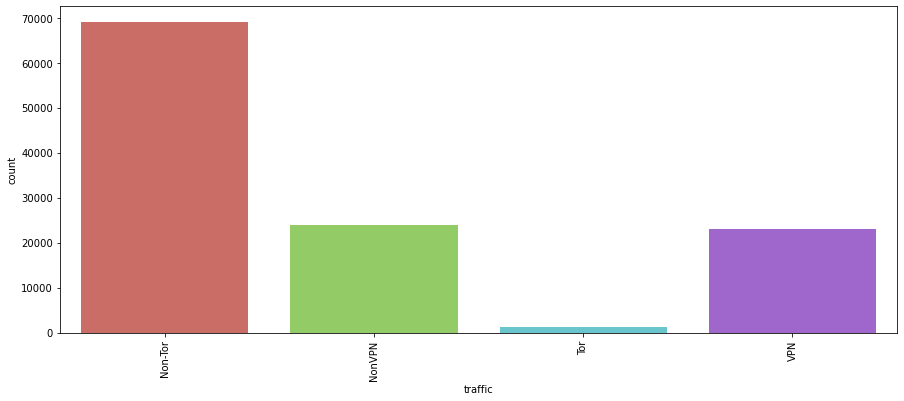

In [102]:
plt.figure(figsize=(15,6))
sns.countplot(data['traffic'], data=data,
              palette='hls')
plt.xticks(rotation=90)
plt.show()

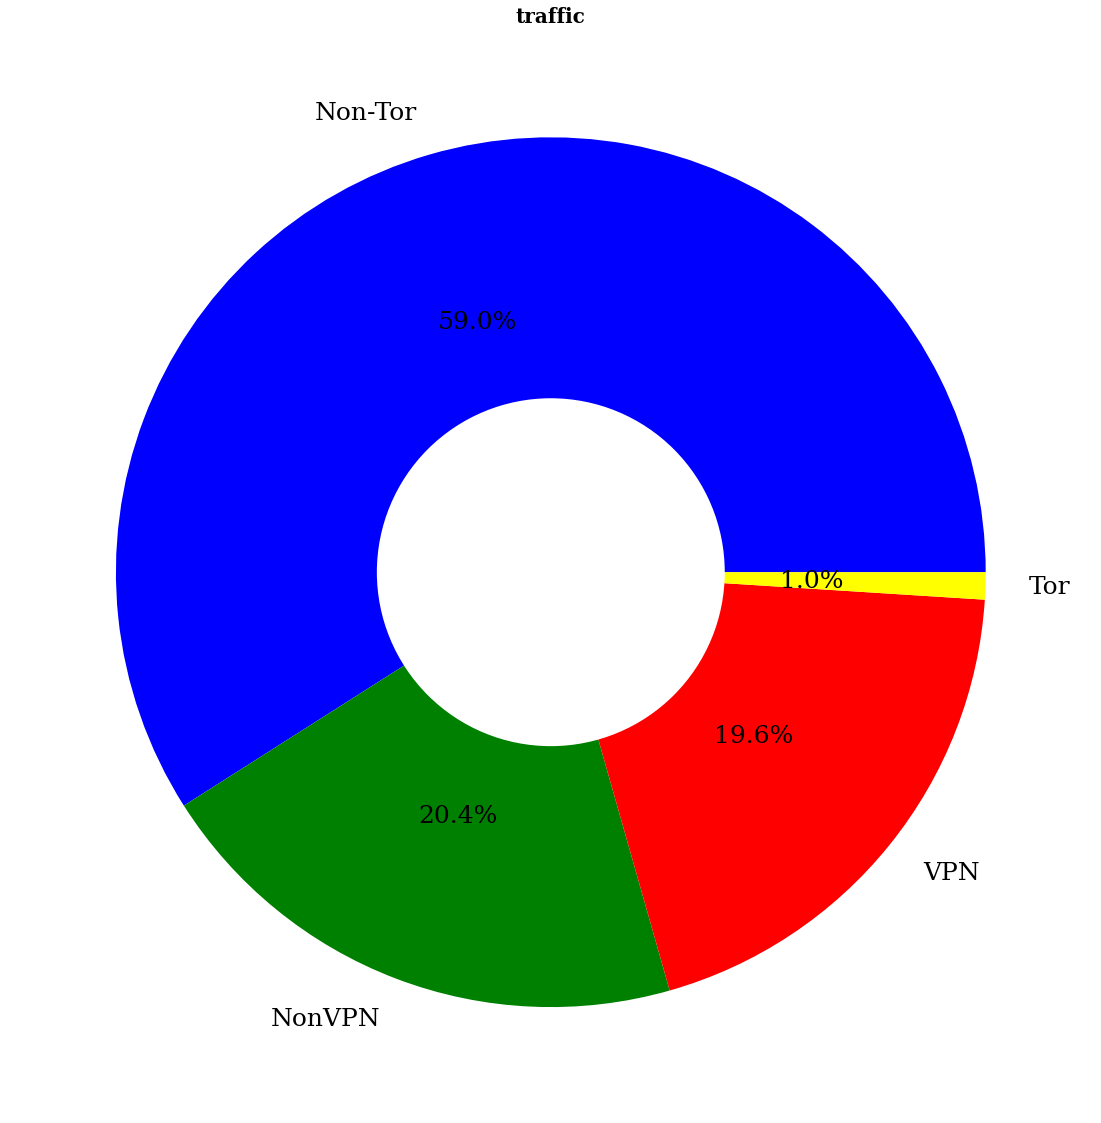

In [103]:
label_data=data['traffic'].value_counts()
explode=(0.0,0.0,0.0,0.0)
plt.figure(figsize=(30,20))
patches, texts, pts= plt.pie(label_data,
                               labels=label_data.index,
                               colors=['blue','green','red','yellow'],
                               autopct='%1.1f%%',
                               textprops={'fontsize':25,
                                          'color':'black',
                                          'family':'serif'})
#plt.setp(pcts, color='black')
hfont={'fontname':'serif', 'weight':'bold'}
plt.title('traffic', size=20, **hfont)
centre_circle=plt.Circle((0,0),0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [104]:
data['application'].unique()

array(['AUDIO-STREAMING', 'Browsing', 'Chat', 'Email', 'File-Transfer',
       'File-transfer', 'P2P', 'Video-Streaming', 'Audio-Streaming',
       'Video-streaming', 'VOIP'], dtype=object)

In [105]:
## we need to do some labels correction
data['application'].loc[data['application'] == 'AUDIO-STREAMING'] = 'Audio-Streaming'
data['application'].loc[data['application'] == 'File-transfer'] = 'File-Transfer'
data['application'].loc[data['application'] == 'Video-streaming'] = 'Video-Streaming'


In [106]:
data['application'].unique()

array(['Audio-Streaming', 'Browsing', 'Chat', 'Email', 'File-Transfer',
       'P2P', 'Video-Streaming', 'VOIP'], dtype=object)

In [107]:
data['application'].value_counts()

Browsing           32714
P2P                24260
Audio-Streaming    17947
Chat               11473
File-Transfer      11173
Video-Streaming     9748
Email               6143
VOIP                3566
Name: application, dtype: int64

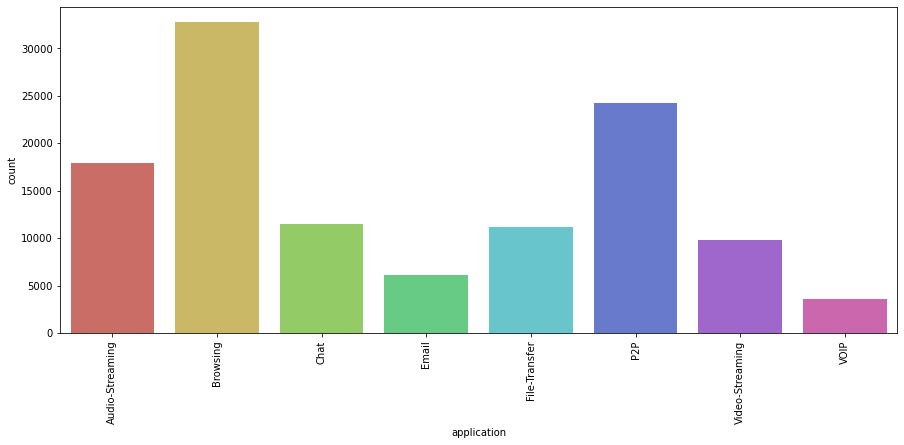

In [108]:
plt.figure(figsize=(15,6))
sns.countplot(data['application'], data=data,
              palette='hls')
plt.xticks(rotation=90)
plt.show()

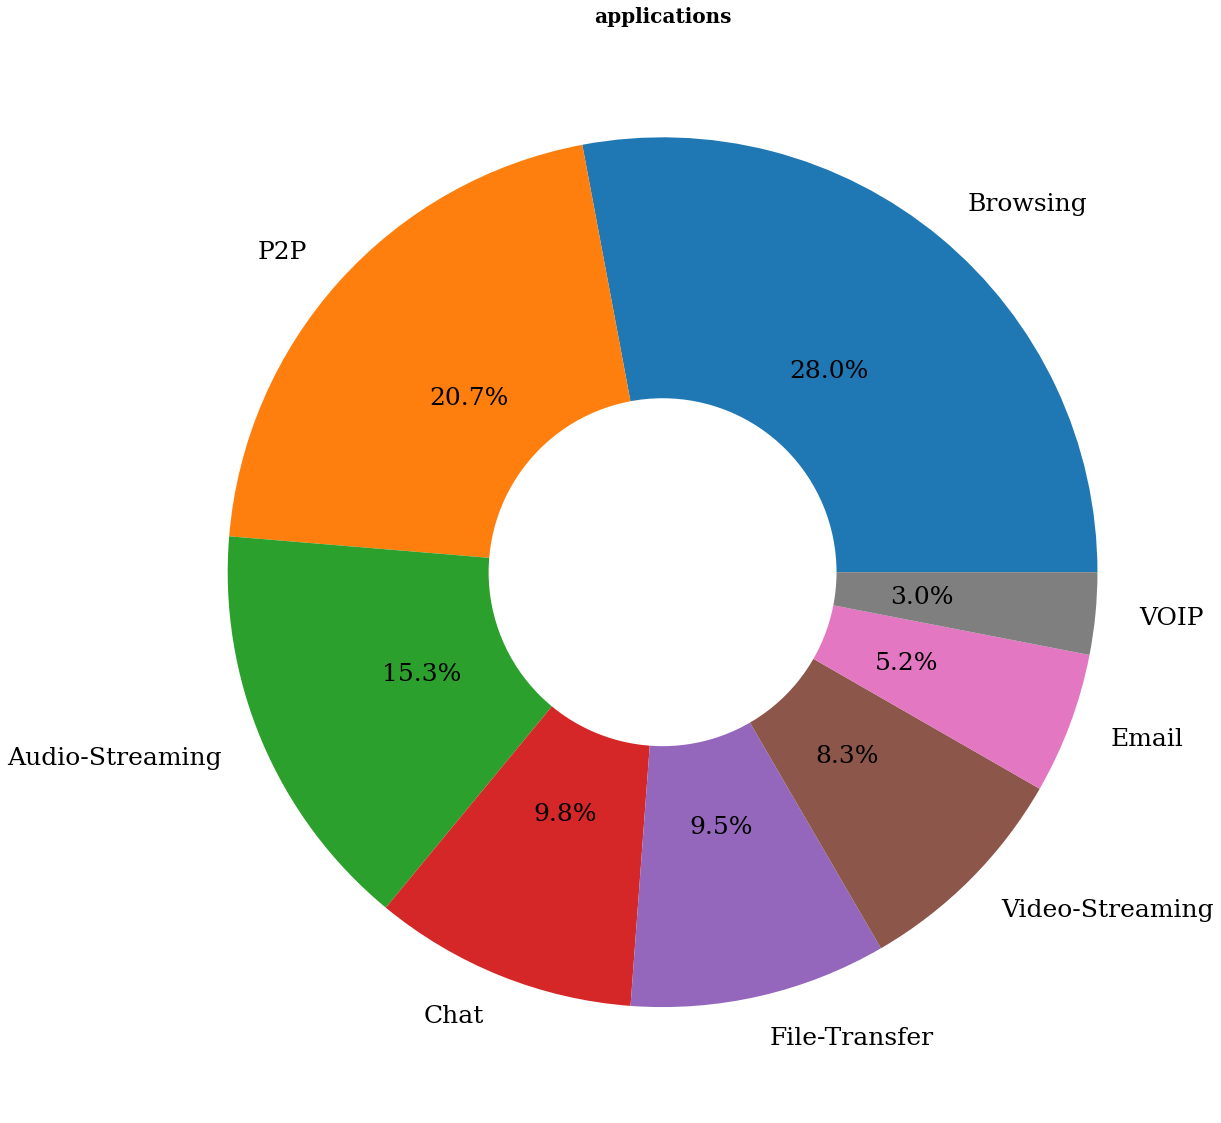

In [109]:
label_data=data['application'].value_counts()
explode=(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
plt.figure(figsize=(30,20))
patches, texts, pts= plt.pie(label_data,
                               labels=label_data.index,
                               autopct='%1.1f%%',
                               textprops={'fontsize':25,
                                          'color':'black',
                                          'family':'serif'})
#plt.setp(pcts, color='black')
hfont={'fontname':'serif', 'weight':'bold'}
plt.title('applications', size=20, **hfont)
centre_circle=plt.Circle((0,0),0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

### inference
There is no balancing in the data.Thus the data should be balanced.But first it is needed to preform feature selection then Data balancing

## Recap 
* There is a huge imbalance concenring the two labels
* The data should be balanced

## Label encoding

In [110]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['traffic'] = label_encoder.fit_transform(data['traffic'])
data['application'] = label_encoder.fit_transform(data['application'])

In [111]:
data['traffic'].unique()

array([0, 1, 2, 3])

In [112]:
data['application'].unique()

array([0, 1, 2, 3, 4, 5, 7, 6])

In [113]:
# IP adresses numeric encoding
def IPtoNumeric(ip):
    packed_ip = socket.inet_aton(ip)
    ip_int = struct.unpack('!L', packed_ip)[0]
    return ip_int

In [114]:
srcIP = data["Src IP"]
numericSrcIP = srcIP.map(IPtoNumeric)
dstIP = data['Dst IP']
numericDstIP = dstIP.map(IPtoNumeric)

In [115]:
data["Src IP"] = numericSrcIP
data["Dst IP"] = numericDstIP

In [116]:
data.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,traffic,application
0,10.152.152.11-216.58.220.99-57158-443-6,177772555,57158,3627736163,443,6,24/07/2015 04:09:48 PM,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
1,10.152.152.11-216.58.220.99-57159-443-6,177772555,57159,3627736163,443,6,24/07/2015 04:09:48 PM,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
2,10.152.152.11-216.58.220.99-57160-443-6,177772555,57160,3627736163,443,6,24/07/2015 04:09:48 PM,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
3,10.152.152.11-74.125.136.120-49134-443-6,177772555,49134,1249740920,443,6,24/07/2015 04:09:48 PM,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0,0
4,10.152.152.11-173.194.65.127-34697-19305-6,177772555,34697,2915189119,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,0,0


## Spliting the data

In [117]:
# Here we need to split data for the two labels
input_data = data.drop(['traffic','application'], axis=1)
traffic_label = data['traffic']
application_label = data['application']
# Split data for the traffic label
Xtrain_traffic, Xtest_traffic, ytrain_traffic, ytest_traffic = train_test_split(
  input_data,traffic_label , random_state=104,test_size=0.25, shuffle=True)

# Split data for the application label
Xtrain_application, Xtest_application, ytrain_application, ytest_application = train_test_split(
  input_data,application_label , random_state=104,test_size=0.25, shuffle=True)